# Direct Access to MUR 1-km in S3 + Analysis

In [1]:
import s3fs
import requests
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import netCDF4
from json import dumps
from io import StringIO
from os.path import dirname, join
from IPython.display import HTML

In [2]:
ShortName = "MUR-JPL-L4-GLOB-v4.1"

### Earthdata Login

You should have a .netrc file in your home directory set up like:

    machine urs.earthdata.nasa.gov 
    login <username> 
    password <password>

### Direct Access to Data from S3

In [3]:
def begin_s3_direct_access(url: str="https://archive.podaac.earthdata.nasa.gov/s3credentials"):
    response = requests.get(url).json()
    return s3fs.S3FileSystem(key=response['accessKeyId'],
                             secret=response['secretAccessKey'],
                             token=response['sessionToken'],
                             client_kwargs={'region_name':'us-west-2'})

fs = begin_s3_direct_access()

type(fs)

s3fs.core.S3FileSystem

### Dataset

In [4]:
mur_Files = fs.glob(join("podaac-ops-cumulus-protected/", ShortName, "*201501*.nc"))

len(mur_Files)

0

In [5]:
mur_Files

[]

In [7]:
mursmall_Files = mur_Files[0:3]

In [8]:
def subset(ds):
    subset_ds = ds.sel(
        lat=slice(18, 25),
        lon=slice(-160, -150)
    )
    return subset_ds

In [10]:
# t3.nano can handle 3 global MUR files at a time

mur_Dataset = xr.open_mfdataset(
    paths=[fs.open(f) for f in mursmall_Files],
    preprocess=subset,
    combine='by_coords',
    mask_and_scale=True,
    decode_cf=True,
    cache=False,
    engine='h5netcdf',
    chunks={'latitude': 70,   # These were chosen arbitrarily. You must specify 
            'longitude': 100, # chunking that is suitable to the data and target
            'time': 30}      # analysis.
)

# mur = mur_Dataset.MUR

mur_Dataset

OSError: no files to open

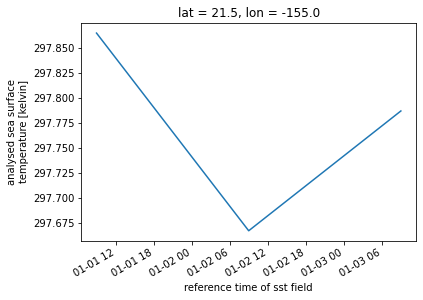

In [38]:
mur_Dataset['analysed_sst'].isel(lat=350, lon=500).plot()

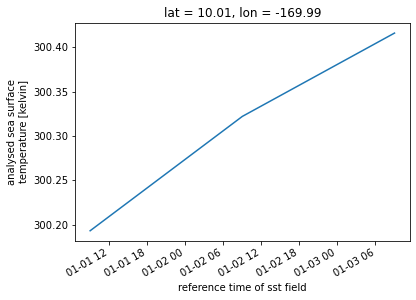

In [14]:
mur_Dataset['analysed_sst'].isel(lat=10000, lon=1000).plot()

In [10]:
mur_Dataset['analysed_sst'].isel(time=1).plot()

MemoryError: Unable to allocate 1.21 GiB for an array with shape (17999, 36000) and data type int16

In [31]:
def read_netcdfs(files, dim, transform_func=None):
    def process_one_path(path):
        # use a context manager, to ensure the file gets closed after use
        with xr.open_dataset(fs.open(path)) as ds:
            # transform_func should do some sort of selection or
            # aggregation
            if transform_func is not None:
                ds = transform_func(ds)
            # load all data from the transformed dataset, to ensure we can
            # use it after closing each original file
            ds.load()
            return ds

#     paths = sorted(fs.glob(files))
    paths = files
    print(files)
    datasets = [process_one_path(p) for p in paths]
    print(datasets)
    combined = xr.concat(datasets, dim)
    return combined

In [32]:
combined = read_netcdfs(mur_Files, dim='time',
                        transform_func=subset)

['podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20150101090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc', 'podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20150102090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc', 'podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20150103090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc', 'podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20150104090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc', 'podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20150105090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc', 'podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20150106090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc', 'podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20150107090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc', 'podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20150108090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc', 'podaac-ops-cumulus-protected/MUR-JPL-L4-GLOB-v4.1/20150109090000-JPL-L4_GHRSST-SSTfnd-

KeyboardInterrupt: 